<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-6143-ML/blob/main/4_linear_regression_case_study_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook
----------------

Many college courses conclude by giving students the opportunity to evaluate the course and the instructor anonymously. In the article “Beauty in the Classroom: Professors’ Pulchritude and Putative Pedagogical Productivity” ([PDF](https://www.nber.org/papers/w9853.pdf)), authors Daniel Hamermesh and Amy M. Parker suggest (based on a data set of teaching evaluation scores collected at UT Austin) that student evaluation scores can partially be predicted by features unrelated to teaching, such as the physical attractiveness of the instructor.

In this notebook, we will use this data to try and predict a course- and instructor-specific “baseline” score (excluding the effect of teaching quality), against which to measure instructor performance.

### Attribution

Parts of this lab are based on a lab assignment from the OpenIntro textbook “Introductory Statistics with Randomization and Simulation” that is released under a Creative Commons Attribution-ShareAlike 3.0 Unported license. The book website is at <https://www.openintro.org/book/isrs/>.

### Data

The data were gathered from end of semester student evaluations for a large sample of professors from the University of Texas at Austin. In addition, six students looked at a photograph of each professor in the sample, and rated the professors’ physical appearance. More specifically:

> Each of the professors’ pictures was rated by each of six undergraduate students: Three women and three men, with one of each gender being a lower-division, two upper-division students (to accord with the distribution of classes across the two levels). The raters were told to use a 10 (highest) to 1 rating scale, to concentrate on the physiognomy of the professor in the picture, to make their ratings independent of age, and to keep 5 in mind as an average.

We are using a slightly modified version of the original data set from the published paper. The dataset was released along with the textbook “Data Analysis Using Regression and Multilevel/Hierarchical Models” (Gelman and Hill, 2007).)

### Setup

We will start by importing relevant libraries, setting up our notebook, reading in the data, and checking that it was loaded correctly.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [30]:
!wget 'https://www.openintro.org/stat/data/evals.csv' -O 'evals.csv'

--2023-10-19 18:16:30--  https://www.openintro.org/stat/data/evals.csv
Resolving www.openintro.org (www.openintro.org)... 192.185.65.127
Connecting to www.openintro.org (www.openintro.org)|192.185.65.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55004 (54K) [text/csv]
Saving to: ‘evals.csv’

evals.csv           100%[===================>]  53.71K   148KB/s    in 0.4s    

2023-10-19 18:16:32 (148 KB/s) - ‘evals.csv’ saved [55004/55004]



In [31]:
df = pd.read_csv('evals.csv')
df.head()
df.columns
df.shape

,score,rank,ethnicity,gender,language,age,cls_perc_eval,cls_did_eval,cls_students,cls_level,...,cls_credits,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg,pic_outfit,pic_color
0,4.7,tenure track,minority,female,english,36,55.81395,24,43,upper,...,multi credit,5,7,6,2,4,6,5.0,not formal,color
1,4.1,tenure track,minority,female,english,36,68.80000,86,125,upper,...,multi credit,5,7,6,2,4,6,5.0,not formal,color
2,3.9,tenure track,minority,female,english,36,60.80000,76,125,upper,...,multi credit,5,7,6,2,4,6,5.0,not formal,color
3,4.8,tenure track,minority,female,english,36,62.60163,77,123,upper,...,multi credit,5,7,6,2,4,6,5.0,not formal,color
4,4.6,tenured,not minority,male,english,59,85.00000,17,20,upper,...,multi credit,4,4,2,2,3,3,3.0,not formal,color


Index(['score', 'rank', 'ethnicity', 'gender', 'language', 'age',
       'cls_perc_eval', 'cls_did_eval', 'cls_students', 'cls_level',
       'cls_profs', 'cls_credits', 'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
       'bty_m1lower', 'bty_m1upper', 'bty_m2upper', 'bty_avg', 'pic_outfit',
       'pic_color'],
      dtype='object')

(463, 21)

Each row in the data frame represents a different course, and columns represent features of the courses and professors. Here’s the data dictionary:

| variable        | description                                                                           |
|-----------------|---------------------------------------------------------------------------------------|
| `score`         | average professor evaluation score: (1) very unsatisfactory - (5) excellent.          |
| `rank`          | rank of professor: teaching, tenure track, tenured.                                   |
| `ethnicity`     | ethnicity of professor: not minority, minority.                                       |
| `gender`        | gender of professor: female, male.                                                    |
| `language`      | language of school where professor received education: english or non-english.        |
| `age`           | age of professor.                                                                     |
| `cls_perc_eval` | percent of students in class who completed evaluation.                                |
| `cls_did_eval`  | number of students in class who completed evaluation.                                 |
| `cls_students`  | total number of students in class.                                                    |
| `cls_level`     | class level: lower, upper.                                                            |
| `cls_profs`     | number of professors teaching sections in course in sample: single, multiple.         |
| `cls_credits`   | number of credits of class: one credit (lab, PE, etc.), multi credit.                 |
| `bty_f1lower`   | beauty rating of professor from lower level female: (1) lowest - (10) highest.        |
| `bty_f1upper`   | beauty rating of professor from upper level female: (1) lowest - (10) highest.        |
| `bty_f2upper`   | beauty rating of professor from second upper level female: (1) lowest - (10) highest. |
| `bty_m1lower`   | beauty rating of professor from lower level male: (1) lowest - (10) highest.          |
| `bty_m1upper`   | beauty rating of professor from upper level male: (1) lowest - (10) highest.          |
| `bty_m2upper`   | beauty rating of professor from second upper level male: (1) lowest - (10) highest.   |
| `bty_avg`       | average beauty rating of professor.                                                   |
| `pic_outfit`    | outfit of professor in picture: not formal, formal.                                   |
| `pic_color`     | color of professor’s picture: color, black & white.                                   |

Source: [OpenIntro book](https://www.openintro.org/book/isrs/).

Note that:

-   `score` is the target variable - this is what we want our model to predict. We expect that the score is a function of the teaching quality, characteristics of the course, and non-teaching related characteristics of the instructor. However, the “true” teaching quality for each course is not known.
-   the variables that begin with a `cls_` prefix are features that relate to the course. These features could potentially affect student evaluations: for example, students may rank one-credit lab courses more highly than multi-credit lecture courses.
-   variables such as `rank`, `ethnicity`, `gender`, `language`, `age`, and the variables with a `bty_` prefix are features that relate to the instructor. They do not necessarily relate to the quality of instruction! These features may also affect student evaluations: for example, students may rate instructors more highly if they are physically attractive.
-   variables with the `pic_` prefix describe the photograph that was shown to the students who provided the `bty_` scores. This should have no effect on the student evaluations, since those were evaluations by students who were enrolled in the course (not the students who were shown the photograph and asked to provide an attractiveness score.) (For your reference: on the bottom of page 7 of the paper, the authors describe why they include this variable and how they used it )

### Explore data

As always, start by exploring the data:

In [32]:
df.describe()

,score,age,cls_perc_eval,cls_did_eval,cls_students,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg
count,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000,463.000000
mean,4.174730,48.365011,74.427788,36.624190,55.177106,3.963283,5.019438,5.213823,3.412527,4.146868,4.751620,4.417844
std,0.543865,9.802742,16.756311,45.018481,75.072800,1.873936,1.934437,2.018224,1.637102,2.110586,1.575266,1.527380
min,2.300000,29.000000,10.416670,5.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.667000
25%,3.800000,42.000000,62.696165,15.000000,19.000000,2.000000,4.000000,4.000000,2.000000,3.000000,4.000000,3.167000
50%,4.300000,48.000000,76.923080,23.000000,29.000000,4.000000,5.000000,5.000000,3.000000,4.000000,5.000000,4.333000
75%,4.600000,57.000000,87.249170,40.000000,60.000000,5.000000,7.000000,6.000000,5.000000,5.000000,6.000000,5.500000
max,5.000000,73.000000,100.000000,380.000000,581.000000,8.000000,9.000000,10.000000,7.000000,9.000000,9.000000,8.167000


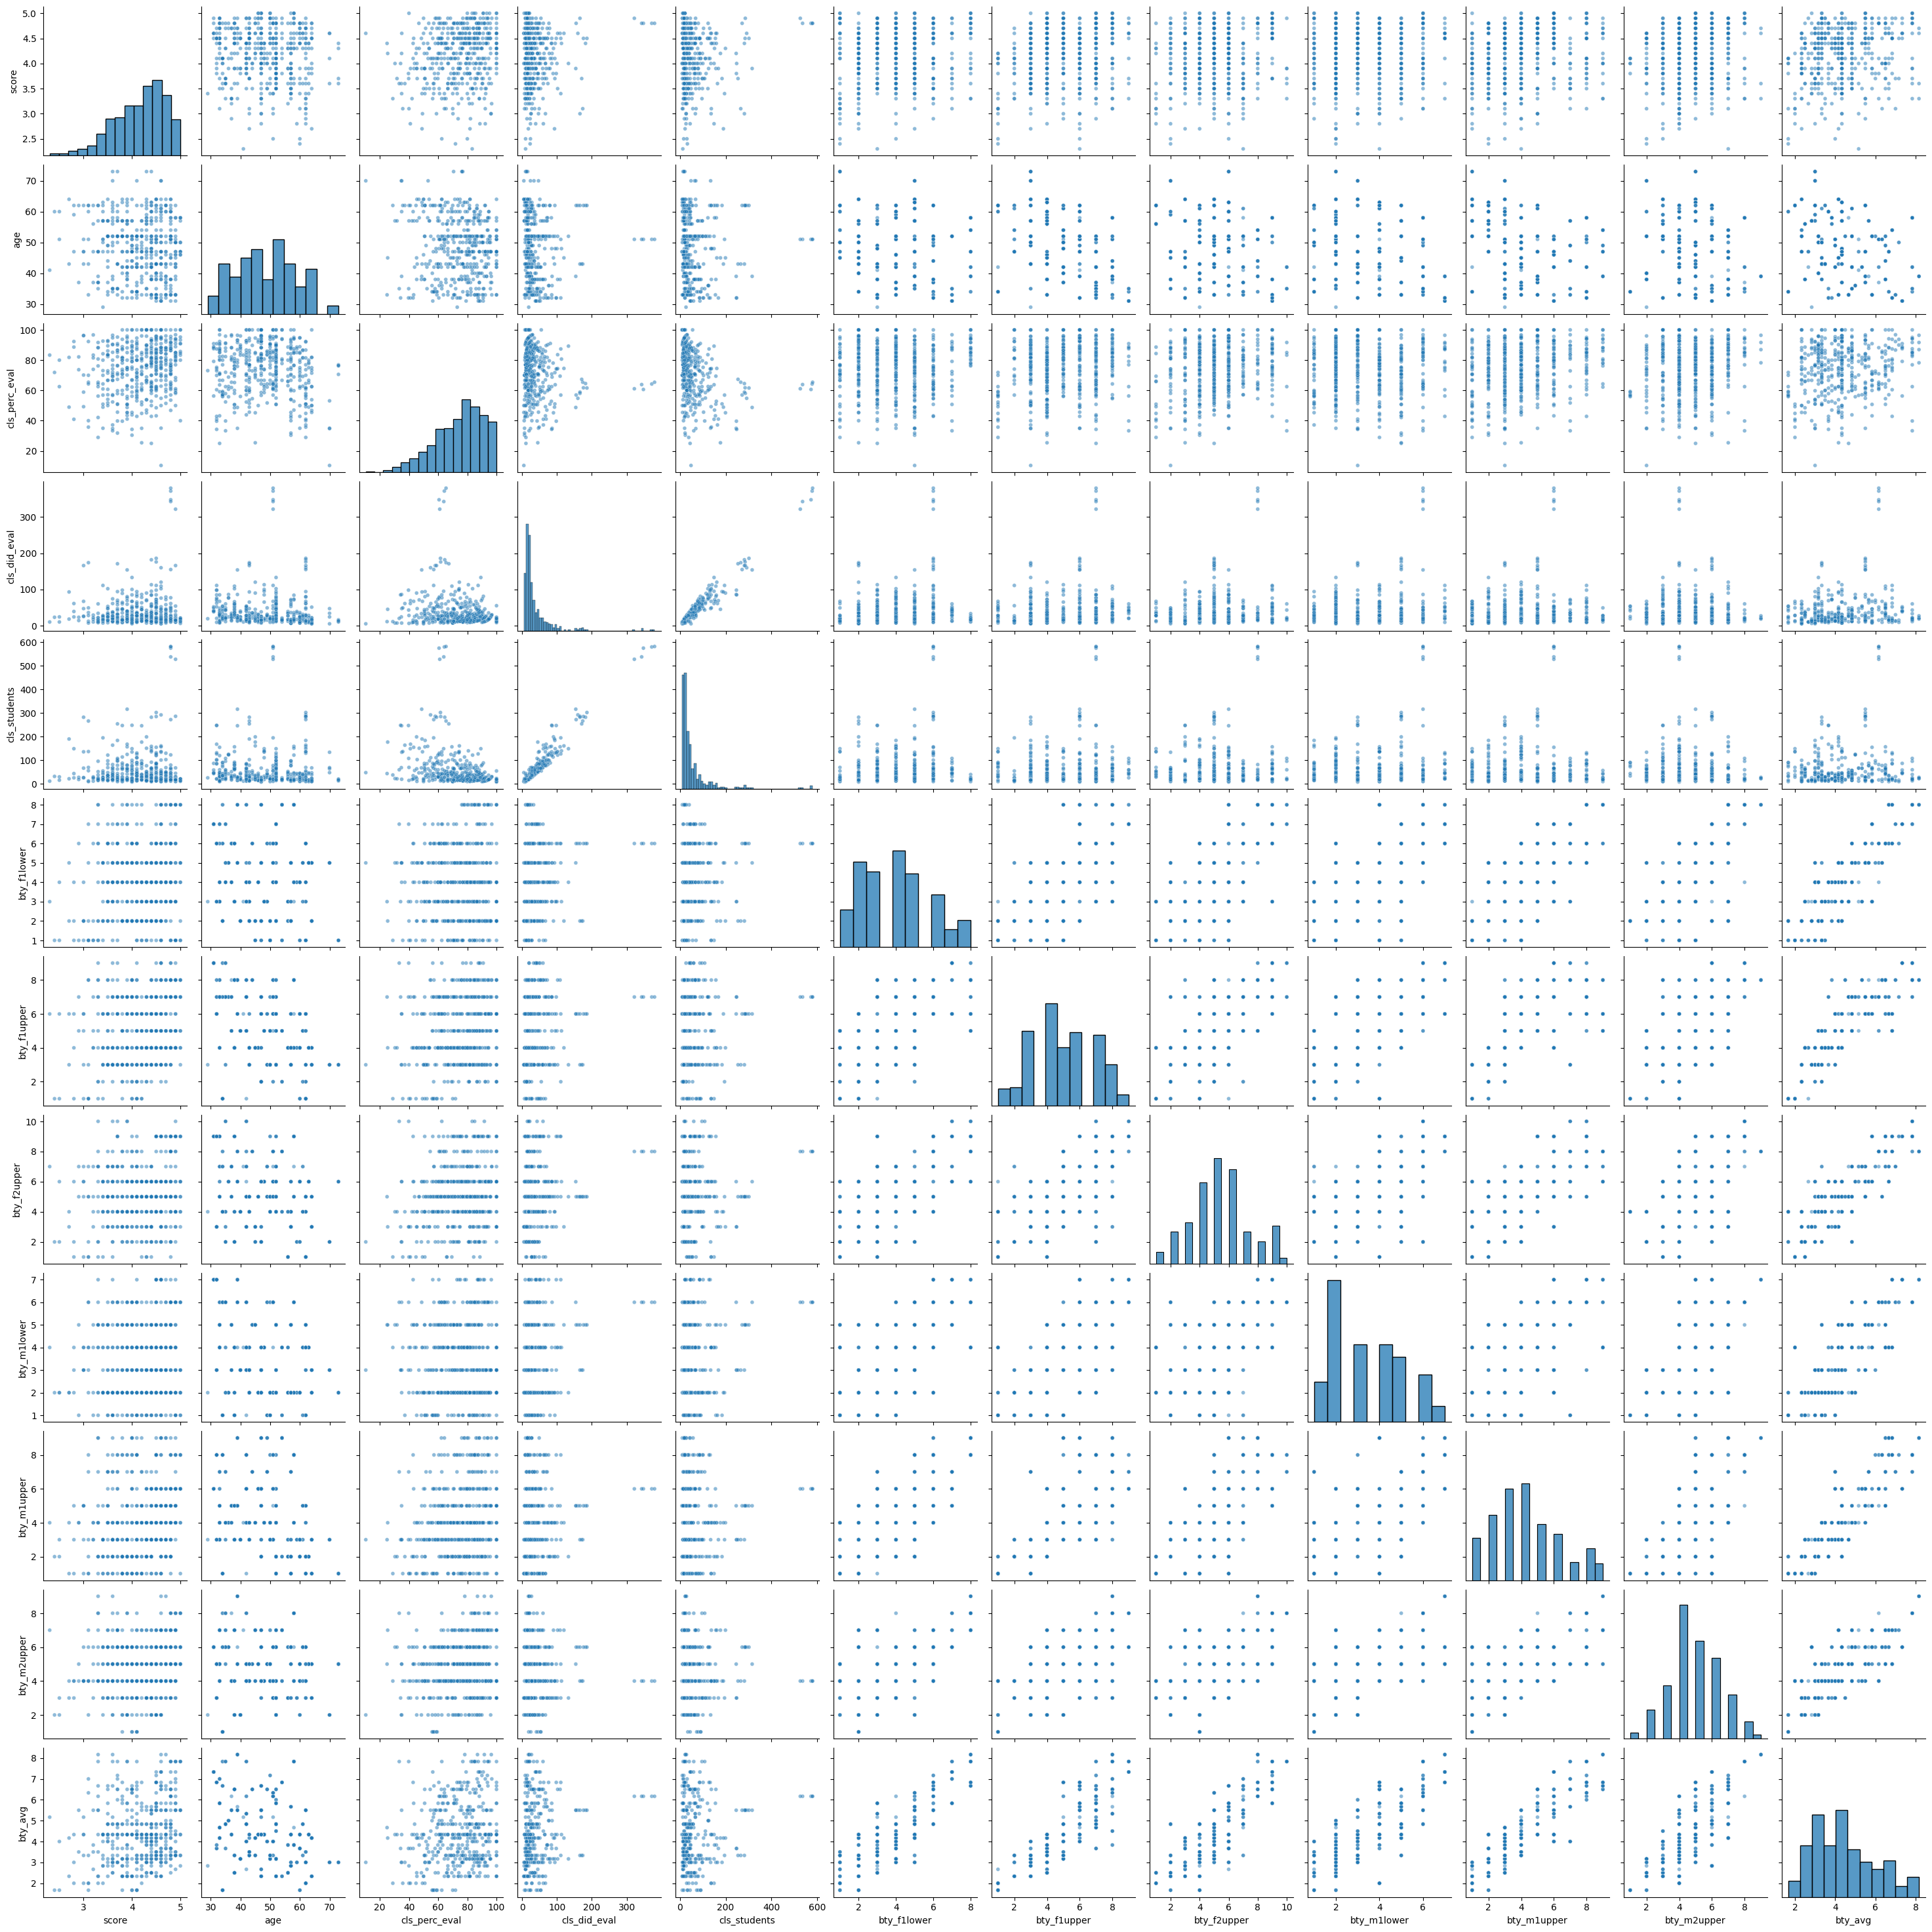

In [5]:
sns.pairplot(df, plot_kws={'alpha':0.5, 'size': 0.1})

With so many numeric variables, the pair plot is hard to read. We can create a pairplot excluding some variables that we don’t expect to be useful for visualization: `cls_perc_eval`, `cls_did_eval`. We will also exclude the individual attractiveness ratings `bty_f1lower`, `bty_f1upper`, `bty_f2upper`, `bty_m1lower`, `bty_m1upper`, `bty_m2upper`, since the overall attractiveness rating is still represented by `bty_avg`.

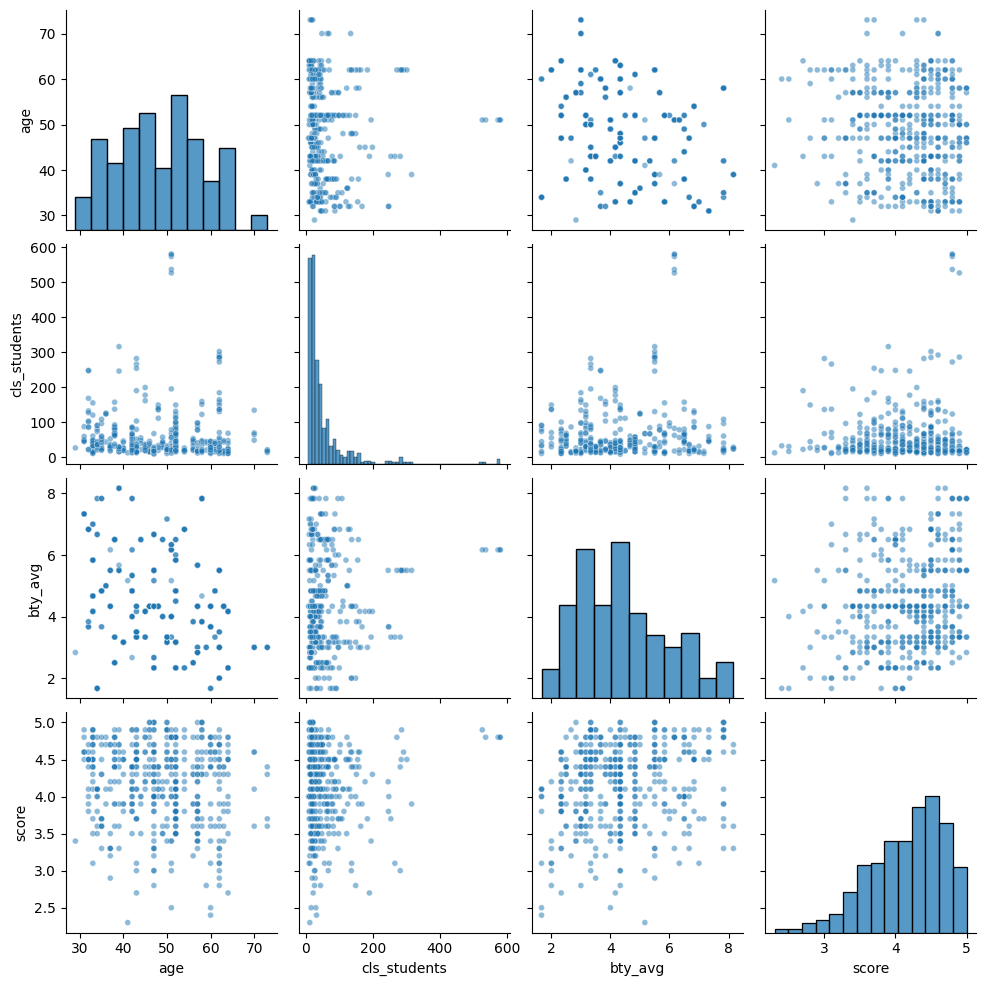

In [33]:
sns.pairplot(df, vars=['age', 'cls_students', 'bty_avg', 'score'], plot_kws={'alpha':0.5, 'size': 0.1})

As part of our exploration of the data, we can also examine the effect of non-numeric variables related to the instructor and the class: `rank`, `ethnicity`, `gender`, `language`, `cls_level`, `cls_profs`, `cls_credits`.

In [34]:
for feature in ['rank', 'ethnicity', 'gender', 'language', 'cls_level', 'cls_profs', 'cls_credits']:
    df.groupby([feature])['score'].describe()

,count,mean,std,min,25%,50%,75%,max
rank,,,,,,,,
teaching,102.0,4.284314,0.498263,3.3,3.9,4.40,4.7,5.0
tenure track,108.0,4.154630,0.561104,2.3,3.7,4.35,4.6,4.9
tenured,253.0,4.139130,0.550262,2.4,3.8,4.20,4.6,5.0


,count,mean,std,min,25%,50%,75%,max
ethnicity,,,,,,,,
minority,64.0,4.071875,0.581588,2.7,3.675,4.05,4.525,5.0
not minority,399.0,4.191228,0.536505,2.3,3.850,4.30,4.600,5.0


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
female,195.0,4.092821,0.563814,2.3,3.7,4.1,4.5,5.0
male,268.0,4.234328,0.521896,2.4,3.9,4.3,4.6,5.0


,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
english,435.0,4.189655,0.547183,2.3,3.9,4.30,4.6,5.0
non-english,28.0,3.942857,0.434979,3.4,3.6,3.75,4.4,4.8


,count,mean,std,min,25%,50%,75%,max
cls_level,,,,,,,,
lower,157.0,4.238217,0.592532,2.5,3.8,4.4,4.7,5.0
upper,306.0,4.142157,0.515104,2.3,3.8,4.2,4.5,5.0


,count,mean,std,min,25%,50%,75%,max
cls_profs,,,,,,,,
multiple,306.0,4.184641,0.551177,2.4,3.8,4.3,4.6,5.0
single,157.0,4.155414,0.530529,2.3,3.8,4.3,4.6,5.0


,count,mean,std,min,25%,50%,75%,max
cls_credits,,,,,,,,
multi credit,436.0,4.147018,0.542464,2.3,3.8,4.2,4.6,5.0
one credit,27.0,4.622222,0.334357,3.5,4.5,4.7,4.9,5.0


#### Discussion Question 1

Describe the relationship between `score` and the overall attractiveness rating `bty_avg`. Is there an apparent correlation? If so, is it a positive or a negative correlation? What about `age` and `cls_students`, do they appear to be correlated with `score`?

Also describe the relationship between `score` and the categorical variables you explored above that are related to characteristics of the *instructor*: `rank`, `ethnicity`, `gender`, `language`. Which of these variables have an apparent correlation with `score`? Is it a positive or a negative correlation?

Are any of the apparent relationships you observed unexpected to you? Explain.

------------------------------------------------------------------------

### Encoding categorical variables

To represent a categorical variable (with no inherent ordering) in a regression, we can use *one hot encoding*. It works as follows:

-   For a categorical variable $x$ with values $1,\cdots,M$
-   Represent with $M$ binary features: $\phi_1, \phi_2, \cdots , \phi_M$
-   Model in regression $w1_1 \phi_1 + \cdots + w_M \phi_M$

We can use the `get_dummies` function in `pandas` for one hot encoding. Create a copy of the dataframe with all categorical variables transformed into indicator (“dummy”) variables, and save it in a new data frame called `df_enc`.

Compare the columns of the `df` data frame versus the `df_enc` data frame.

In [35]:
df_enc = pd.get_dummies(df)
df_enc.columns

Index(['score', 'age', 'cls_perc_eval', 'cls_did_eval', 'cls_students',
       'bty_f1lower', 'bty_f1upper', 'bty_f2upper', 'bty_m1lower',
       'bty_m1upper', 'bty_m2upper', 'bty_avg', 'rank_teaching',
       'rank_tenure track', 'rank_tenured', 'ethnicity_minority',
       'ethnicity_not minority', 'gender_female', 'gender_male',
       'language_english', 'language_non-english', 'cls_level_lower',
       'cls_level_upper', 'cls_profs_multiple', 'cls_profs_single',
       'cls_credits_multi credit', 'cls_credits_one credit',
       'pic_outfit_formal', 'pic_outfit_not formal', 'pic_color_black&white',
       'pic_color_color'],
      dtype='object')

In [36]:
df_enc.head()

,score,age,cls_perc_eval,cls_did_eval,cls_students,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,...,cls_level_lower,cls_level_upper,cls_profs_multiple,cls_profs_single,cls_credits_multi credit,cls_credits_one credit,pic_outfit_formal,pic_outfit_not formal,pic_color_black&white,pic_color_color
0,4.7,36,55.81395,24,43,5,7,6,2,4,...,0,1,0,1,1,0,0,1,0,1
1,4.1,36,68.80000,86,125,5,7,6,2,4,...,0,1,0,1,1,0,0,1,0,1
2,3.9,36,60.80000,76,125,5,7,6,2,4,...,0,1,0,1,1,0,0,1,0,1
3,4.8,36,62.60163,77,123,5,7,6,2,4,...,0,1,0,1,1,0,0,1,0,1
4,4.6,59,85.00000,17,20,4,4,2,2,3,...,0,1,1,0,1,0,0,1,0,1


In [37]:
df_enc['language_english'].head(), df_enc['language_non-english'].head()

(0    1
 1    1
 2    1
 3    1
 4    1
 Name: language_english, dtype: uint8,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: language_non-english, dtype: uint8)

### Split data

Next, we split the encoded data into a training set (70%) and test set (30%). We will be especially interested in evaluating the model performance on the test set. Since it was not used to train the model parameters (intercept and coefficients), the performance on this data gives us a better idea of how the model may perform on new data.

We’ll use the `train_test_split` method in `sklearn`’s `model_selection` module. Since it randomly splits the data, we’ll pass a random “state” into the function that makes the split repeatable (same split every time we run this notebook) and ensures that everyone in the class will have exactly the same split.

In [38]:
train, test = model_selection.train_test_split(df_enc, test_size=0.3, random_state=9)
# why 9? see https://dilbert.com/strip/2001-10-25
train.shape
test.shape

(324, 31)

(139, 31)

### Simple linear regression

Now we are finally ready to train a regression model.

Since the article is nominally abou the attractiveness of the instructor, we will train the simple linear regression on the `bty_avg` feature.

In the cell that follows, write code to

-   use `sklearn` to fit a simple linear regression model on the training set, using `bty_avg` as the feature on which to train. Save your fitted model in a variable `reg_simple`.
-   print the intercept and coefficient of the model.
-   use `predict` on the fitted model to estimate the evaluation score on the training set, and save this array in `y_pred_train`.
-   use `predict` on the fitted model to estimate the evaluation score on the test set, and save this array in `y_pred_test`.

Then run the cell after that one, which will show you the training data, the test data, and your regression line.

In [39]:
reg_simple = LinearRegression().fit(train[['bty_avg']], train['score'])
reg_simple.coef_
reg_simple.intercept_

y_pred_train = reg_simple.predict(train[['bty_avg']])
y_pred_test = reg_simple.predict(test[['bty_avg']])

array([0.07367795])

3.842544653270748

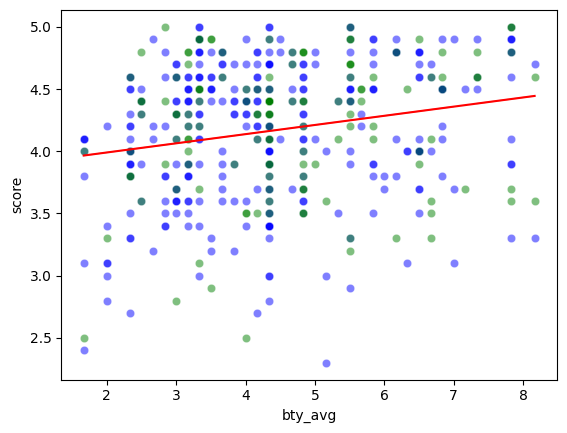

In [40]:
sns.scatterplot(data=train, x="bty_avg", y="score", color='blue', alpha=0.5);
sns.scatterplot(data=test, x="bty_avg", y="score", color='green', alpha=0.5);
sns.lineplot(data=train, x="bty_avg", y=y_pred_train, color='red');

### Evaluate simple linear regression performance

Next, we will evaluate our model performance.

In the following cell, write a *function* to compute key performance metrics for your model:

-   compute the R2 score on your training data
-   compute the MSE on your training data
-   compute the MSE, divided by the sample variance of `score`, on your training data. Recall that this metric tells us the ratio of average error of your model to average error of prediction by mean.
-   and compute the same three metrics for your test set

In [41]:
def regression_performance(y_true_train, y_pred_train, y_true_test, y_pred_test):

    r2_train = metrics.r2_score(y_true_train, y_pred_train)
    mse_train = metrics.mean_squared_error(y_true_train, y_pred_train)
    norm_mse_train = metrics.mean_squared_error(y_true_train, y_pred_train)/(np.std(y_true_train)**2)

    r2_test = metrics.r2_score(y_true_test, y_pred_test)
    mse_test = metrics.mean_squared_error(y_true_test, y_pred_test)
    norm_mse_test = metrics.mean_squared_error(y_true_test, y_pred_test)/(np.std(y_true_test)**2)

    #print("Training:   %f %f %f" % (r2_train, mse_train, norm_mse_train))
    #print("Test:       %f %f %f" % (r2_test, mse_test, norm_mse_test))

    return [r2_train, mse_train, norm_mse_train, r2_test, mse_test, norm_mse_test]

Call your function to print the performance of the simple linear regression. Is a simple linear regression on `bty_avg` better than a “dumb” model that predicts the mean value of `score` for all samples?

In [42]:
vals = regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)

In [43]:
vals

[0.042169087759789003,
 0.2871218052541188,
 0.9578309122402111,
 0.011239031127678434,
 0.2799645389571157,
 0.9887609688723219]

### Multiple linear regression

Next, we’ll see if we can improve model performance using multiple linear regression, with more features included.

To start, we need to decide which features to use as input to our model. One possible approach is to use every feature in the dataset excluding the target variable, `score`.

You can build and view this list of features by running:

In [44]:
features = df_enc.columns.drop(['score'])
features

Index(['age', 'cls_perc_eval', 'cls_did_eval', 'cls_students', 'bty_f1lower',
       'bty_f1upper', 'bty_f2upper', 'bty_m1lower', 'bty_m1upper',
       'bty_m2upper', 'bty_avg', 'rank_teaching', 'rank_tenure track',
       'rank_tenured', 'ethnicity_minority', 'ethnicity_not minority',
       'gender_female', 'gender_male', 'language_english',
       'language_non-english', 'cls_level_lower', 'cls_level_upper',
       'cls_profs_multiple', 'cls_profs_single', 'cls_credits_multi credit',
       'cls_credits_one credit', 'pic_outfit_formal', 'pic_outfit_not formal',
       'pic_color_black&white', 'pic_color_color'],
      dtype='object')

In the following cell, write code to

-   use `sklearn` to fit a linear regression model on the training set, using the `features` array as the list of features to train on. Save your fitted model in a variable `reg_multi`.
-   print a table of the features used in the regression and the coefficient assigned to each. If you have saved your fitted regression in a variable named `reg_multi`, you can create and print this table with:

``` python
df_coef = pd.DataFrame(data =
                        {'feature': features,
                         'coefficient': reg_multi.coef_})
df_coef
```

In [45]:
reg_multi = LinearRegression().fit(train[features], train['score'])
df_coef = pd.DataFrame(data =
                        {'feature': features,
                         'coefficient': reg_multi.coef_})
df_coef

,feature,coefficient
0,age,-0.009493
1,cls_perc_eval,0.004385
2,cls_did_eval,0.002983
3,cls_students,-0.001427
4,bty_f1lower,7.022264
5,bty_f1upper,7.052930
6,bty_f2upper,7.032261
7,bty_m1lower,6.959419
8,bty_m1upper,6.999172
9,bty_m2upper,6.978719


#### Discussion Question 2

Look at the list of features and coefficients, especially those related to the attractiveness ratings.

Are these results surprising, based on the results of the simple linear regression? Explain your answer.

------------------------------------------------------------------------

### Effect of collinearity

Note especially the coefficients associated with each of the individual attractiveness rankings, and the coefficient associated with the average attractiveness ranking. Each of these features separately seems to have a large effect; however, because they are strongly *collinear*, they cancel one another out.

(You should be able to see the collinearity clearly in the pairplot you created.)

In the following cell, write code to

-   create a new `features` array, that drops the *individual* attractiveness rankings in addition to the `score` variable (but do *not* drop the average attractiveness ranking)
-   use `sklearn` to fit a linear regression model on the training set, using the new `features` array as the list of features to train on. Save your fitted model in a variable `reg_avgbty`.
-   print a table of the features used in the regression and the coefficient assigned to each.

In [46]:
features = df_enc.columns.drop(['score',
    'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
    'bty_m1lower', 'bty_m1upper', 'bty_m2upper'])
reg_avgbty = LinearRegression().fit(train[features], train['score'])

df_coef = pd.DataFrame(data =
                        {'feature': features,
                         'coefficient': reg_avgbty.coef_})
df_coef

,feature,coefficient
0,age,-0.009297
1,cls_perc_eval,0.004900
2,cls_did_eval,0.003737
3,cls_students,-0.001740
4,bty_avg,0.040577
5,rank_teaching,0.075283
6,rank_tenure track,-0.059429
7,rank_tenured,-0.015854
8,ethnicity_minority,-0.111830
9,ethnicity_not minority,0.111830


#### Discussion Question 3

Given the model parameters you have found, which is associated with the strongest effect (on average) on the evaluation score:

-   Instructor ethnicity
-   Instructor gender

(Note that in general, we cannot use the coefficient to compare the effect of features that have a different range. But both ethnicity and gender are represented by binary one hot-encoded variables.)

------------------------------------------------------------------------

### Evaluate multiple regression model performance

Evaluate the performance of your `reg_avgbty` model. In the next cell, write code to:

-   use the `predict` function on your fitted regression to find $\hat{y}$ for all samples in the *training* set, and save this in an array called `y_pred_train`
-   use the `predict` function on your fitted regression to find $\hat{y}$ for all samples in the *test* set, and save this in an array called `y_pred_test`
-   call the `regression_performance` function you wrote in a previous cell, and print the performance metrics on the training and test set.

In [47]:
y_pred_train = reg_avgbty.predict(train[features])
y_pred_test = reg_avgbty.predict(test[features])

vals = regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)

In [48]:
vals

[0.21084960007910047,
 0.23655771028767414,
 0.7891503999208996,
 0.10999489011969865,
 0.25200213004088645,
 0.8900051098803016]

#### Discussion Question 4

Based on the analysis above, what portion of the variation in instructor teaching evaluation can be explained by the factors unrelated to teaching performance, such as the physical characteristics of the instructor?

------------------------------------------------------------------------

#### Discussion Question 5

Based on the analysis above, is your model better at predicting instructor teaching scores than a “dumb” model that just assigns the mean teaching score to every instructor? Explain.

------------------------------------------------------------------------

#### Discussion Question 6

Suppose you are hired by the ECE department to develop a classifer that will identify high-performing faculty, who will then be awarded prizes for their efforts.

Based on the analysis above, do you think it would be fair to use scores on teaching evaluations as an input to your classifier? Explain your answer.

------------------------------------------------------------------------

### Exploring unexpected correlation

There are some features that we do *not* expect to be correlated with the instructor’s score.

For example, consider the “features” related to the photograph used by the students who rated the instructor’s attractiveness.

There is no reason that characteristics of an instructor’s photograph - whether it was in black and white or color, how the instructor was dressed in the photograph - should influence the ratings of students in the instructor’s class. (These students did not even see the photograph.)

In the next cell, we will write code to

-   create a new `features` array that drops the `score` variable, all of the individual attractiveness rankings, and the variables related to the photograph used for attractiveness rankings.
-   use it to fit a model (saved in `reg_nopic`).
-   use `reg_nopic` to predict the evaluation scores on both the training and test set
-   compute the same set of metrics as above.

In [49]:
features = df_enc.columns.drop(['score',
    'bty_f1lower', 'bty_f1upper', 'bty_f2upper',
    'bty_m1lower', 'bty_m1upper', 'bty_m2upper',
    'pic_outfit_formal', 'pic_outfit_not formal',
    'pic_color_black&white', 'pic_color_color'])

reg_nopic = LinearRegression().fit(train[features], train['score'])


y_pred_train = reg_nopic.predict(train[features])
y_pred_test = reg_nopic.predict(test[features])

vals = regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)


#### Discussion Question 7

Is your model less predictive when features related to the instructor photograph are excluded? Explain.

------------------------------------------------------------------------

When a machine learning model seems to use a feature that is not expected to be correlated with the target variable (such as the characteristics of the instructor’s photograph…), this can sometimes be a signal that information is “leaking” between the training and test set.

In this dataset, each row represents a single course. However, some instructors teach more than one course, and an instructor might get similar evaluation scores on all of the courses he or she teaches.

(According to the paper for which this dataset was collected, 94 faculty members taught the 463 courses represented in the dataset, with some faculty members teaching as many as 13 courses.)

For example, consider the output of the following command, which prints all of the one credit courses in the data:

In [50]:
df.loc[df['cls_credits']=='one credit']

,score,rank,ethnicity,gender,language,age,cls_perc_eval,cls_did_eval,cls_students,cls_level,...,cls_credits,bty_f1lower,bty_f1upper,bty_f2upper,bty_m1lower,bty_m1upper,bty_m2upper,bty_avg,pic_outfit,pic_color
124,3.5,teaching,not minority,female,english,52,89.47369,17,19,upper,...,one credit,6,6,4,2,4,7,4.833,not formal,color
179,4.4,tenure track,minority,female,english,47,100.00000,16,16,lower,...,one credit,2,6,6,3,5,4,4.333,not formal,color
185,4.6,tenure track,minority,female,english,47,95.23810,20,21,lower,...,one credit,2,6,6,3,5,4,4.333,not formal,color
245,4.2,teaching,not minority,female,english,50,75.00000,24,32,lower,...,one credit,2,3,5,2,3,4,3.167,not formal,color
246,4.7,teaching,not minority,female,english,50,66.66666,14,21,lower,...,one credit,2,3,5,2,3,4,3.167,not formal,color
339,4.8,tenure track,not minority,male,english,43,53.57143,15,28,lower,...,one credit,3,4,4,2,4,4,3.500,not formal,color
340,4.9,tenure track,not minority,male,english,43,60.00000,18,30,lower,...,one credit,3,4,4,2,4,4,3.500,not formal,color
343,4.5,tenure track,not minority,male,english,43,94.44444,17,18,lower,...,one credit,3,4,4,2,4,4,3.500,not formal,color
344,4.9,tenure track,not minority,male,english,43,84.61539,22,26,lower,...,one credit,3,4,4,2,4,4,3.500,not formal,color
345,4.4,tenure track,not minority,male,english,43,60.00000,18,30,lower,...,one credit,3,4,4,2,4,4,3.500,not formal,color


We observe that 10 out of 27 one-credit courses are taught by what seems to be the same instructor - we don’t know his name, but let’s call him John. John is a teaching-track professor, minority ethnicity, male, English-language trained, 50 years old, average attractiveness 3.333, and whose photograph is in color and not formal.

This provides a clue regarding the apparent importance of the `cls_credits` variable and other “unexpected” variables in predicting the teaching score.

Certain variables may be used by the model to identify the instructor, and then learn a relationship between the *individual instructor* and his or her typical evaluation score, instead of learning a true relationship between the *variable* and the evaluation score.

In other words: the model learns “an instructor who is teaching-track, minority, male, English-language-trained, 50 years old, has average attractiveness 3.333, and whose photograph is in color and not formal typically scores X” - but it’s really just learning “John typically scores X”.

To see if this is plausible, let’s add an “instructor ID” to each row in our data frame. The data set doesn’t include an instructor ID column, but we can still uniquely identify every instructor by looking at the combination of rank, ethnicity, gender, language of training, age, attractiveness score, and characteristics of the photo (formal or not, black and white or color).

In [51]:
instructor_id = df[['rank', 'ethnicity', 'gender', 'language',
        'pic_outfit', 'pic_color']].agg('-'.join, axis=1)
instructor_id +=  '-' + df['age'].astype(str)
instructor_id +=  '-' + df['bty_avg'].astype(str)

df_enc = df_enc.assign(instructor_id = instructor_id)

df_enc['instructor_id'].head()

0    tenure track-minority-female-english-not forma...
1    tenure track-minority-female-english-not forma...
2    tenure track-minority-female-english-not forma...
3    tenure track-minority-female-english-not forma...
4    tenured-not minority-male-english-not formal-c...
Name: instructor_id, dtype: object

Let’s plot the frequency with which each “instructor ID” appears in the data:

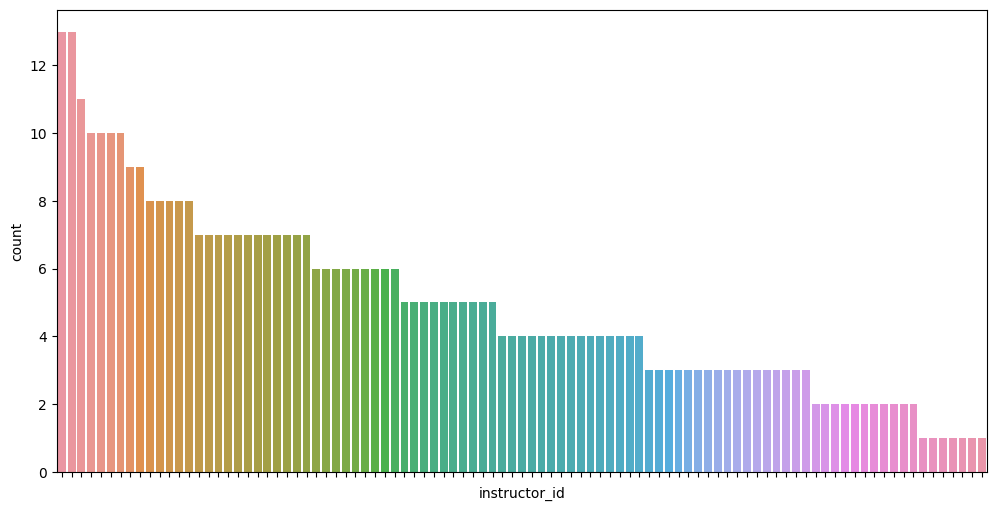

In [52]:
_  = plt.figure(figsize=(12,6))
ax = sns.countplot(x="instructor_id", data=df_enc,
    order=df_enc['instructor_id'].value_counts().index)
_  = ax.set(xticklabels=[])

There are 95 unique instructor IDs. According to the paper, the data set includes 94 instructors. We are working with a slightly modified version of the data from the paper. It seems we’ve been able to uniquely identify every instructor.

Some instructors are represented as many as 13 times in the dataset. Only a handful of instructors appear only once in the data.

Furthermore, we can see that most instructors get similar scores for all of the courses they teach, with a few exceptions:

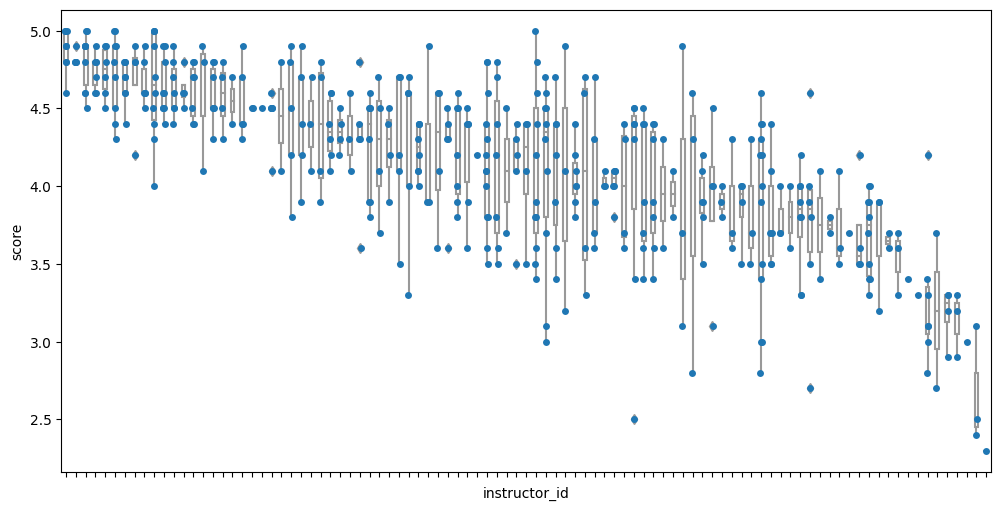

In [53]:
score_order = df_enc.groupby('instructor_id')['score'].agg('mean').sort_values(ascending=False).index

_  = plt.figure(figsize=(12,6))
ax = sns.boxplot(x=df_enc['instructor_id'], y=df_enc['score'],
                 order=score_order,
                 color='white', width=0.4)
ax = sns.stripplot(x=df_enc['instructor_id'], y=df_enc['score'],
                   order=score_order)
_  = ax.set(xticklabels=[])

To explore this issue further, we will repeat our analysis using two different ways of splitting the dataset:

1.  **Random split**: shuffle data and split it into training and test sets. Train the model using the training data, then evaluate its performance on the test set. (This is what we have done so far.)
2.  **Group split**: split data into training and test sets in a way that ensures that each individual *instructor* is represented in either the training data or the test data, but not both. Train the model using the training data, then evaluate its performance on the test set. If the model is “memorizing” individual instructors, rather than learning a general relationship between features and teaching evaluation score, it will have much worse performance on the test set, because it has to predict scores for instructors it hasn’t “seen” yet.

Because the dataset is small, the performance evaluation may be influenced by the random sample of rows that happen to end up in the training vs. test set. (If a few rows more rows than usual that are very “easy” to predict are placed in the test set, we might see better performance than we would with a different test set.) So, we will also repeat the splitting procedure several times, and look at the *average* performance across different train-test splits.

In [54]:
n_splits = 10
metrics_rs = np.zeros((n_splits, 6))
rs = model_selection.KFold(n_splits=n_splits, shuffle=True)

for i, split in enumerate(rs.split(df_enc)):
    train_idx, test_idx = split
    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]

    features = df_enc.columns.drop(['score', 'instructor_id'])

    # train a multiple linear regression using
    # the train dataset and the list of features created above
    # save the fitted model in reg_rndsplit
    # then use the model to create y_pred_train and y_pred_test,
    # the model predictions on the training set and test set.
    # Finally, return the array of model performance metrics

    reg_rndsplit = LinearRegression().fit(train[features], train['score'])

    y_pred_train = reg_rndsplit.predict(train[features])
    y_pred_test = reg_rndsplit.predict(test[features])

    metrics_rs[i] = regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)


np.mean(metrics_rs, axis=0)


array([0.21588615, 0.23140491, 0.78411385, 0.12317885, 0.25428793,
       0.87682115])

With this approach to splitting the data, the model appears to have some predictive value on the test set (which is supposed to represent performance on “new” data.)

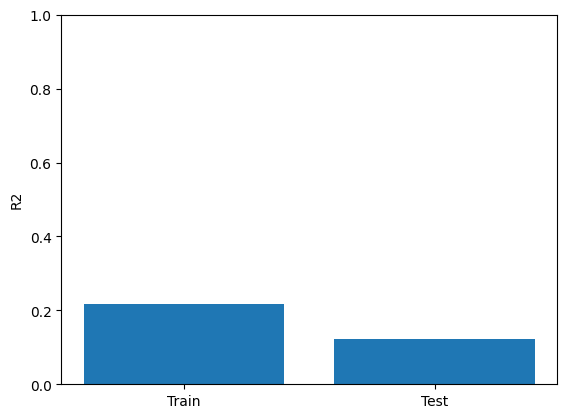

In [55]:
_ = plt.bar(x=['Train', 'Test'], height=np.mean(metrics_rs, axis=0)[[0,3]])
_ = plt.ylabel("R2")
_ = plt.ylim(0, 1)

Next, we will perform our splits, train a model, and get performance metrics according to the second scheme, in which an instructor may be present in either the training set or the test set, but not both.

In [56]:
n_splits = 10
metrics_gs = np.zeros((n_splits, 6))
gs = model_selection.GroupKFold(n_splits=n_splits)

for i, split in enumerate(gs.split(df_enc,
                                   df_enc['score'],
                                   df_enc['instructor_id'])):

    train_idx, test_idx = split

    train = df_enc.iloc[train_idx]
    test = df_enc.iloc[test_idx]

    features = df_enc.columns.drop(['score', 'instructor_id'])

    # train a multiple linear regression using
    # the train dataset and the list of features created above
    # save the fitted model in reg_grpsplit
    # then use the model to create y_pred_train and y_pred_test,
    # the model predictions on the training set and test set.
    # Finally, return the array of model performance metrics

    reg_grpsplit = LinearRegression().fit(train[features], train['score'])

    y_pred_train = reg_grpsplit.predict(train[features])
    y_pred_test = reg_grpsplit.predict(test[features])

    metrics_gs[i] = regression_performance(train['score'], y_pred_train, test['score'], y_pred_test)

np.mean(metrics_gs, axis=0)


array([ 0.22092182,  0.22984319,  0.77907818, -0.03138834,  0.29278308,
        1.03138834])

With the second approach to splitting the data, we can see that the model has no predictive value on the test set.

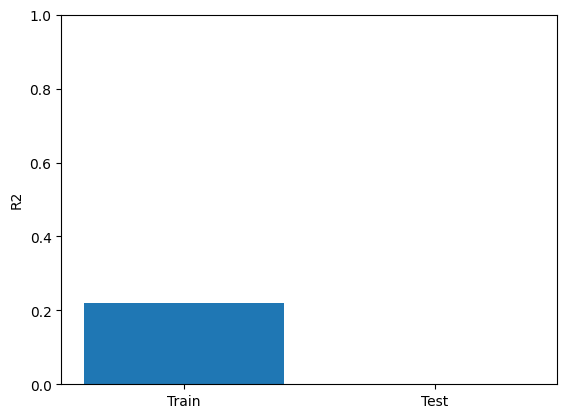

In [57]:
_ = plt.bar(x=['Train', 'Test'], height=np.mean(metrics_gs, axis=0)[[0,3]])
_ = plt.ylabel("R2")
_ = plt.ylim(0, 1)

#### Discussion Question 8

Based on your analysis above, do you think your model will be useful to predict the teaching evaluation scores of a new faculty member at UT Austin, based on his or her physical characteristics and the characteristics of the course?

------------------------------------------------------------------------

### Review: what went wrong?

In this case study, we saw *two* problems:

The first problem is that the model was “memorizing” the individual instructors that appeared in the training data, rather than learning a general relationship between the features and the target variable. This is known as *overfitting*.

Usually, when a model is overfitting, it will be evident in the evaluation on the test set, because a model that overfits on training data will have excellent performance on training data and poor performance on test data. That’s where the second problem comes in: data leakage! We expect the model to be able to predict a baseline score for instructors it has not been trained on, but our model was being trained on data from a set of instructors, then evaluated on data from the same instructors.

As a result of this data leakage, the model had overly optimistic error on the test set. The model appeared to generalize to new, unseen, data, but in fact would not generalize to different instructors.

One of the “red flags” that helped us identify the problem was that the model seemed to be learning from features that we know are not really informative - for example, the characteristics of the photo used to derive the attractiveness ratings. This is often a sign of data leakage.